# Support Vector Regression

For the third model I will use support vector regression (SVR). In the course we learnt about support vector machines (SVM) for classification. They can be extended to solve regression problems as well. Scikit-learn contains a SVR estimator that I will use. SVR can, like SVM, used with different kernels. I will try the RBF and polynomial kernels.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [1]:
# needs scikit-learn version >= 0.22 because of permutation_importance

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

from features import categorical_features, skewed_features, unskewed_features, cols_idxs
from scores import save_score

## Read the data

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data2.csv"))
df.set_index("commune_id", inplace=True)
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

In [3]:
# Work around PowerTransformer bug: https://github.com/scikit-learn/scikit-learn/issues/14959
df["per_capita_tax_income"] = StandardScaler(with_std=False).fit_transform(df["per_capita_tax_income"].values.reshape(-1, 1))

## Train/test split

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df["typology"])
X_train = df_train.drop(columns="po_value").values
y_train = df_train["po_value"].values
X_test = df_test.drop(columns="po_value").values
y_test = df_test["po_value"].values

# numerical indexes for different kinds of features, will be needed in preprocessor later
categorical_idxs = cols_idxs(df_train.drop(columns="po_value"), categorical_features)
skewed_idxs = cols_idxs(df_train.drop(columns="po_value"), skewed_features)
unskewed_idxs = cols_idxs(df_train.drop(columns="po_value"), unskewed_features)

## RBF Kernel

### First run (default parameters)

C = 1.0  "Regularization parameter. The strength of the regularization is inversely proportional to C"  
gamma = "scale" -> (1 / (n_features * X.var()) = 0.014 "Kernel coefficient"

In [5]:
preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    (PowerTransformer(standardize=True), skewed_idxs),
    (StandardScaler(), skewed_idxs + unskewed_idxs),
    remainder = "passthrough"
)

svr_rbf = make_pipeline(preprocessor, SVR(kernel="rbf"))
svr_rbf.fit(X_train, y_train)
svr_rbf_test_pred = svr_rbf.predict(X_test)
print("With default params:")
print("SVR (rbf) MAE = {:.3f}".format(mean_absolute_error(y_test, svr_rbf_test_pred)))
print("SVR (rbf) R^2 = {:.3f}".format(svr_rbf.score(X_test, y_test)))

With default params:
SVR (rbf) MAE = 0.155
SVR (rbf) R^2 = 0.727


With default parameters, the model already performs almost as good as the best linear regression model (MAE = 0.153, $R^2$ = 0.749).

In [6]:
# what is the actual default value of gamma? (1 / (n_features * X.var())
X_pp = preprocessor.transform(X_train)
print(1 / (X_pp.shape[1] * X_pp.var())) # 0.014

0.013725732657351303


### Second run (tune C, gamma)

In [7]:
parameters = {
    "svr__C": np.logspace(-5, 5, 31),
    "svr__gamma": np.logspace(-10, 0, 11)
}
gcv_rbf = GridSearchCV(svr_rbf, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12)
gcv_rbf.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv_rbf.best_params_)) # {'svr__C': 21.54434690031882, 'svr__gamma': 0.001}
print("Best MAE = {:.3f}".format(-gcv_rbf.best_score_)) #  0.1630.158

Grid search / cross-validation:
Best params = {'svr__C': 21.54434690031882, 'svr__gamma': 0.001}
Best MAE = 0.158


The best value for the regularization strength C is larger than the default (1.0), meaning weaker regularization.

Gamma is smaller than the default (0.14), that means the decision boundary is taking into account samples farther away, which results in a smoother decision boundary (is that a valid term talking about support-vector *regression*?)

https://www.youtube.com/watch?v=m2a2K4lprQw An explanation of SVM gamma

In [8]:
gcv_rbf_test_pred = gcv_rbf.predict(X_test)
gcv_rbf_test_mae = mean_absolute_error(y_test, gcv_rbf_test_pred)
gcv_rbf_test_r2 = r2_score(y_test, gcv_rbf_test_pred)
print("On test data:")
print("Tuned SVR (rbf) MAE = {:.3f}".format(gcv_rbf_test_mae))
print("Tuned SVR (rbf) R^2 = {:.3f}".format(gcv_rbf_test_r2))
save_score("svr_rbf", gcv_rbf_test_mae, gcv_rbf_test_r2, os.path.join("data","results", "model_scores.csv"))

On test data:
Tuned SVR (rbf) MAE = 0.147
Tuned SVR (rbf) R^2 = 0.764


This is the best model I got so far (and will remain so). But in the end, the differences between all of the models are small.

### Cross validation ranking

In [9]:
df_gcv_rbf = pd.DataFrame(gcv_rbf.cv_results_)[
    ['rank_test_score', 'mean_test_score', 'std_test_score', 'param_svr__C', 'param_svr__gamma']
    ].sort_values(by='rank_test_score')
df_gcv_rbf.head(5)

,rank_test_score,mean_test_score,std_test_score,param_svr__C,param_svr__gamma
216,1,-0.158311,0.002403,21.5443,0.001
227,2,-0.158987,0.002902,46.4159,0.001
184,3,-0.159212,0.002908,2.15443,0.01
324,4,-0.159226,0.004778,46415.9,1e-05
313,5,-0.159302,0.005782,21544.3,1e-05


I find it noteworthy that the regularization strength of the top hyper-parameter search results varies widely. It looks like the model can work with much weaker regularization (46415) if it compensates with reducing gamme.

### Validation curve

Plot the validation curve to study the impact of the regularization strength C on the model's performance.

In [10]:
sns.set_style('whitegrid')
def validationcurve_plot(name, param_range, train_scores, valid_scores, ax):
    """Plots a validation curve and marks the best test score."""
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    sns.lineplot(param_range, train_scores_mean, label="train", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
    sns.lineplot(param_range, valid_scores_mean, label="validation", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)
    ax.set_title("Validation curve for " + name)

    best_idx = valid_scores_mean.argmin()
    ax.scatter(param_range[best_idx], valid_scores_mean[best_idx], marker='x', c='red', zorder=10, label="best")

    ax.legend()

In [11]:
svr_rbf_2 = make_pipeline(preprocessor, SVR(kernel="rbf", gamma=gcv_rbf.best_params_["svr__gamma"]))
param_range = np.logspace(-5, 5, 31)
train_scores, valid_scores = validation_curve(svr_rbf_2, X_train, y_train, param_name="svr__C",
                                              scoring = "neg_mean_absolute_error", param_range=param_range,
                                              cv=5, n_jobs=12)

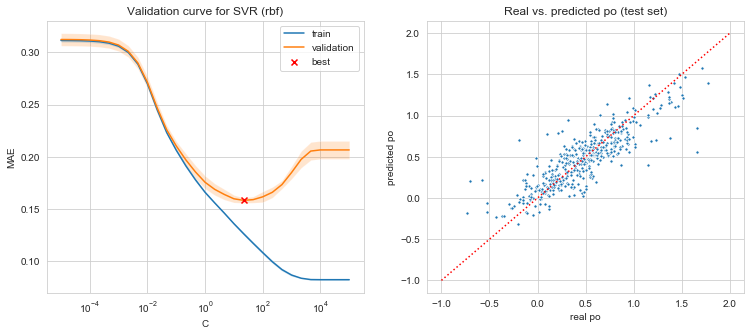

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

validationcurve_plot("SVR (rbf)", param_range, -train_scores, -valid_scores, ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("MAE")
sns.scatterplot(y_test, svr_rbf_test_pred, s=10, ax=ax2)
ax2.set_xlabel("real po")
ax2.set_ylabel("predicted po")
ax2.set_title("Real vs. predicted po (test set)")
ax2.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()

This looks unlike the validation curves of other models I have seen so far because the local optimum on the validation error is very pronounced.

Just like all the other models, predictions for communes on the edges (po_value < 0.5 or po_value > 1.2) are too centric.

## Polynomial Kernel

### First run (default parameters, almost)

degree=2 (real default 3) polynomial degree  
C = 1.0   regularization strength  
gamma = "scale" (0.014) kernel coefficient

Degree was manually tuned to 2 because it scores better (0.162) than 3 (0.181) or 1 (0.164).

In [13]:
preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    (PowerTransformer(standardize=True), skewed_idxs),
    (StandardScaler(), skewed_idxs + unskewed_idxs),
    remainder = "passthrough"
)

svr_poly = make_pipeline(preprocessor, SVR(kernel="poly", degree=1))
svr_poly.fit(X_train, y_train)
svr_poly_test_pred = svr_poly.predict(X_test)
print("With default params:")
print("SVR (poly, deg=2) MAE = {:.3f}".format(mean_absolute_error(y_test, svr_poly_test_pred)))
print("SVR (poly, deg=2) R^2 = {:.3f}".format(r2_score(y_test, svr_poly_test_pred)))

With default params:
SVR (poly, deg=2) MAE = 0.164
SVR (poly, deg=2) R^2 = 0.710


Not as good as with RBF kernel and defaults.

### Second run (tune degree, C, gamma)

This grid search is very expensive. It takes one hour on a modern 6-core Intel CPU at 4.3 GHz. Values of C > 10^3 could not be computed because it does not terminate. (Possible improvement idea: use sklearn.svm.LinearSVR: "should scale better to large numbers of samples").

In [14]:
parameters = {
    "svr__degree": [1, 2],
    "svr__C": np.logspace(-5, 3, 9), # fit is not terminating for C > 10^3
    "svr__gamma": np.logspace(-10, 0, 11)
}
gcv_poly = GridSearchCV(svr_poly, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, verbose=True)
gcv_poly.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv_poly.best_params_)) # 
print("Best MAE (poly)= {:.3f}".format(-gcv_poly.best_score_))
# Best params = {'svr__C': 1000.0, 'svr__degree': 1, 'svr__gamma': 0.01}
# Best MAE (poly)= 0.166

Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    6.7s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   15.9s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   45.1s
[Parallel(n_jobs=12)]: Done 990 out of 990 | elapsed: 54.5min finished


Grid search / cross-validation:
Best params = {'svr__C': 1000.0, 'svr__degree': 1, 'svr__gamma': 0.01}
Best MAE (poly)= 0.166


The best polynomial degree is one, meaning it's a linear SVR model, there is no benefit from higher-order combinations of features. (Mayne that can be considered similar to tree boosting where the max-depth hyper-parameter also sticked to 3 and did not benefit from higher values, that would allow more feature interactions).

Best C is much larger than the default (1.0), meaning weaker regularization.

Gamma is 0.01, very close to the default value.

In [15]:
gcv_poly_test_pred = gcv_poly.predict(X_test)
gcv_poly_test_mae = mean_absolute_error(y_test, gcv_poly_test_pred)
gcv_poly_test_r2 = r2_score(y_test, gcv_poly_test_pred)
print("On test data:")
print("Tuned SVR (poly) MAE = {:.3f}".format(gcv_poly_test_mae))
print("Tuned SVR (poly) R^2 = {:.3f}".format(gcv_poly_test_r2))
save_score("svr_poly", gcv_poly_test_mae, gcv_poly_test_r2, os.path.join("data","results", "model_scores.csv"))

On test data:
Tuned SVR (poly) MAE = 0.151
Tuned SVR (poly) R^2 = 0.753


That is a really good score (relatively). Only the RBF kernel is better. It beats the best linear regression and gradient boosting model (not by much). I was surprised because it is also only a linear model (degree=1).

### Cross validation ranking

In [16]:
df_gcv_poly = pd.DataFrame(gcv_poly.cv_results_)[
    ['rank_test_score', 'mean_test_score', 'std_test_score', 'param_svr__degree', 'param_svr__C', 'param_svr__gamma']
    ].sort_values(by='rank_test_score')
df_gcv_poly.head(5)

,rank_test_score,mean_test_score,std_test_score,param_svr__degree,param_svr__C,param_svr__gamma
184,1,-0.165596,0.005876,1,1000,0.01
142,2,-0.165597,0.005902,1,10,1
163,3,-0.165627,0.005831,1,100,0.1
164,4,-0.165681,0.005682,1,100,1
185,5,-0.165929,0.005918,1,1000,0.1


Again, C can vary widely without the score really changing.

### Validation curve

Plot the validation curve to study the impact of the regularization strength C on the model's performance.

In [17]:
svr_poly_2 =  make_pipeline(preprocessor, SVR(kernel="poly", degree=gcv_poly.best_params_["svr__degree"],
                                              gamma=gcv_poly.best_params_["svr__gamma"], verbose=True))
param_range = np.logspace(-5, 4, 10)
train_scores, valid_scores = validation_curve(svr_poly_2, X_train, y_train, param_name="svr__C",
                                              scoring = "neg_mean_absolute_error", param_range=param_range,
                                              cv=5, n_jobs=12)

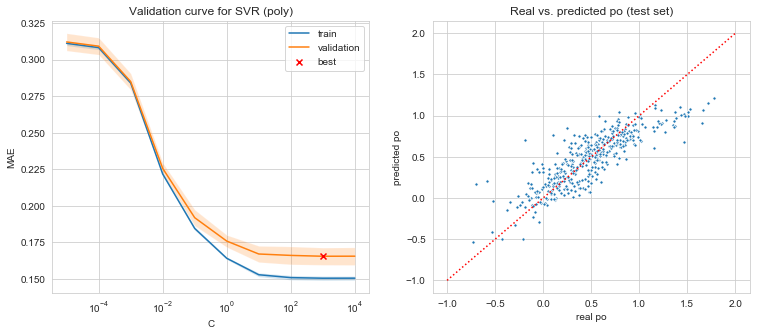

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

validationcurve_plot("SVR (poly)", param_range, -train_scores, -valid_scores, ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("MAE")
sns.scatterplot(y_test, svr_poly_test_pred, s=10, ax=ax2)
ax2.set_xlabel("real po")
ax2.set_ylabel("predicted po")
ax2.set_title("Real vs. predicted po (test set)")
ax2.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()

With strong regularization, the model is underfitting. The performance quickly improves starting at $C > 10^{-4}$ and levels off at $C = 10^1$. If you compare this with the validation curve from linear regression, remember that alpha is proportional to regularization strength and C is inversely proportional to it.

Looking at the prediction errors, you can see that on the right edge the predictions are more off (too centric) compared with the RBF kernel.

# Feature importance
I calculate the permutation feature importance with the rbf kernel and best parameters from above.

In [19]:
preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    (PowerTransformer(standardize=True), skewed_idxs),
    (StandardScaler(), skewed_idxs + unskewed_idxs),
    remainder = "passthrough"
)

# Best params = {'svr__C': 21.54434690031882, 'svr__gamma': 0.001}
estimator = make_pipeline(preprocessor, SVR(kernel="rbf", C=21.54, gamma=0.001))
estimator.fit(X_train, y_train)

perm_importances = permutation_importance(estimator, X_train, y_train, scoring='neg_mean_absolute_error',
                                          n_repeats=10, n_jobs=12, random_state=0)

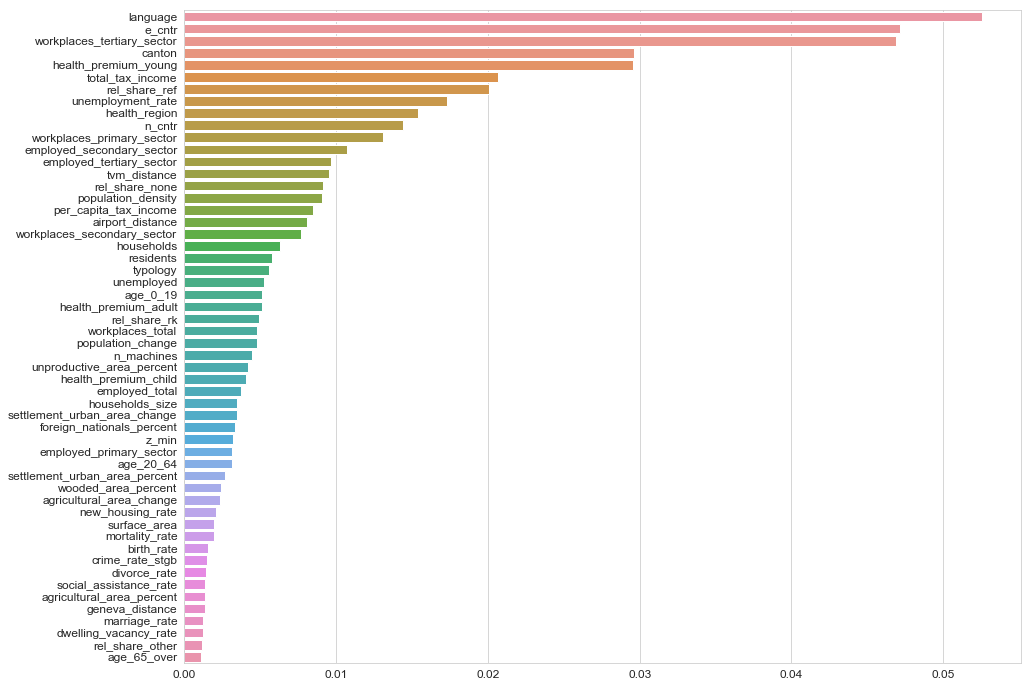

In [20]:
perm_sorted_idx = (-perm_importances["importances_mean"]).argsort()
perm_importances_sorted = perm_importances["importances_mean"][perm_sorted_idx]
cols_sorted = df_train.drop(columns="po_value").columns[perm_sorted_idx]

plt.figure(figsize = (15,12))
bp = sns.barplot(x=perm_importances_sorted, y=cols_sorted)
bp.tick_params(labelsize="large")

- the most important features are similar to the ones from the other models; with some replacements like workplaces_tertiary_sector (strongly correlated with residents)
- the number of important features is more similar to linear regression than gradient tree boosting (12 feature > 0.01, linear regression 18 features > 0.01)
- the value of the importance of the top features is much smaller than for the top features in linear regression
- canton is important again (like linear regression, unlike gradient tree boosting)

## With reduced features

Again I build a model with a reduced feature set of 10 features based on the top-ranked features from above.

In [21]:
reduced_features = [
    "language",
    "e_cntr",
    "n_cntr",
    "residents", # workplaces_tertiary_sector, total_tax_income
    "canton",
    "health_premium_young",
    "per_capita_tax_income",
    "rel_share_ref",
    "unemployment_rate",
    "workplaces_primary_sector"
]

X_train_red = df_train[reduced_features].values
X_test_red = df_test[reduced_features].values

categorical_features_red = set(categorical_features).intersection(set(reduced_features))
skewed_features_red = set(skewed_features).intersection(set(reduced_features))
unskewed_features_red = set(unskewed_features).intersection(set(reduced_features))

categorical_idxs_red = cols_idxs(df[reduced_features], categorical_features_red)
skewed_idxs_red = cols_idxs(df[reduced_features], skewed_features_red)
unskewed_idxs_red = cols_idxs(df[reduced_features], unskewed_features_red)

In [22]:
preprocessor_red = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs_red),
    (PowerTransformer(standardize=True), skewed_idxs_red),
    (StandardScaler(), skewed_idxs_red + unskewed_idxs_red),
    remainder = "passthrough"
)

# Best params = {'svr__C': 21.54434690031882, 'svr__gamma': 0.001}
svr_rbf_red = make_pipeline(preprocessor_red, SVR(kernel="rbf", C=21.54, gamma=0.001))
svr_rbf_red.fit(X_train_red, y_train)

perm_importances_red = permutation_importance(svr_rbf_red, X_train_red, y_train, scoring='neg_mean_absolute_error',
                                              n_repeats=10, n_jobs=12, random_state=0)

svr_rbf_red_test_pred = svr_rbf_red.predict(X_test_red)
svr_rbf_red_test_mae = mean_absolute_error(y_test, svr_rbf_red_test_pred)
svr_rbf_red_test_r2 = r2_score(y_test, svr_rbf_red_test_pred)
print("On test data:")
print("SVR (rbf) (red.) MAE = {:.3f}".format(svr_rbf_red_test_mae))
print("SVR (rbf) (red.) R^2 = {:.3f}".format(svr_rbf_red_test_r2))
save_score("svr_red", svr_rbf_red_test_mae, svr_rbf_red_test_r2, os.path.join("data", "results", "model_scores.csv"))

On test data:
SVR (rbf) (red.) MAE = 0.158
SVR (rbf) (red.) R^2 = 0.736


The difference in MAE vs. the full-feature model is a bit larger here than for the other models (0.011 vs. 0.005, 0.007), but in absolute values it is as good as the linear regression reduced model and better than the gradient tree boosting reduced model.

| &nbsp; | full | red. |
| --- | --- | --- |
|MAE|0.147|0.158|
|$R^2$|0.764|0.736|

In [23]:
perm_sorted_idx_red = (-perm_importances_red["importances_mean"]).argsort()
perm_importances_sorted_red = perm_importances_red["importances_mean"][perm_sorted_idx_red]
cols_sorted_red = df_train[reduced_features].columns[perm_sorted_idx_red]

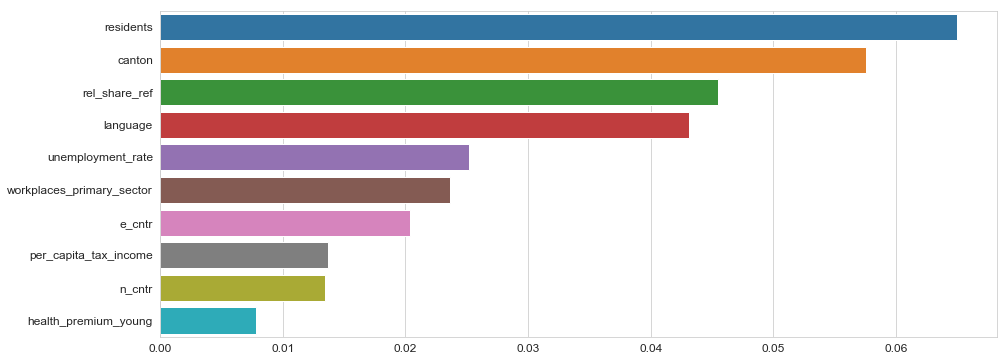

In [24]:
plt.figure(figsize = (15,6))
bp_red = sns.barplot(x=perm_importances_sorted_red, y=cols_sorted_red)
bp_red.tick_params(labelsize="large")

Summary: a limited set of features that represent distinctive concepts like geography, population size, economy, language, health or religion are enough to build a model with performance close to the full-featured model.